### word2vec + UMAP + HDBSCAN

Dataset: "Amazon Reviews: Musical Instruments" from https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/

In [1]:
# import pandas as pd
import json

folder_path = "D:/WUT/NLP/"
data_path = folder_path + "Musical_Instruments.json"
meta_path = folder_path + "meta_Musical_Instruments.json"

def read_json_array(path):
  data = []
  with open(path, 'r') as file:
    for line in file:
      json_object = json.loads(line.strip())
      data.append(json_object)
  return data

data = read_json_array(data_path)
meta = read_json_array(meta_path)

In [4]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.models import Word2Vec
import numpy as np
import umap # pip install umap-learn
import hdbscan
import matplotlib.pyplot as plt
import tools as tl

In [ ]:
texts = [review['reviewText'] for review in data if 'reviewText' in review]
print(f'Amount: {len(texts)}')


Amount: 1511675


In [ ]:
tokenized_texts = [tl.tokenize(text) for text in texts]

In [6]:
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=50, window=5, min_count=1, workers=4)

In [ ]:
import numpy as np

def get_text_embedding(tokens, model):
    embeddings = []
    for token in tokens:
        if token in model.wv:
            embeddings.append(model.wv[token])
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    return np.mean(embeddings, axis=0)

word2vec_embeddings = np.array([get_text_embedding(tokens, w2v_model) for tokens in tokenized_texts])


In [ ]:
subset = word2vec_embeddings[:10000]  # Use the first n samples for umap training

umap_model = umap.UMAP(n_components=2, random_state=2024)  # Set n_components=2 for 2D projection, or 3 for 3D
umap_model.fit(subset)
umap_embeddings = umap_model.transform(word2vec_embeddings)

c:\ProgramFiles\Anaconda3\envs\nlp10\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
import pandas as pd

# algos = ['kmeans', 'hdbscan', 'agg', 'spectral', 'gmm', 'dbscan']
algos = ['hdbscan']

results_df = pd.DataFrame(columns=["Number of clusters", "Silhouette Score"])

for algo in algos:
  umap_clusters = tl.perform_clustering_without_PCA(umap_embeddings, algo=algo)
  word2vec_clustrs = tl.perform_clustering_without_PCA(word2vec_embeddings, algo=algo)

  results_df.loc[f"{algo} (UMAP)"] = tl.calc_cluster_metrics(umap_clusters, umap_embeddings)
  results_df.loc[f"{algo} (Word2Vec)"] = tl.calc_cluster_metrics(word2vec_clustrs, word2vec_embeddings)

results_df

c:\ProgramFiles\Anaconda3\envs\nlp10\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

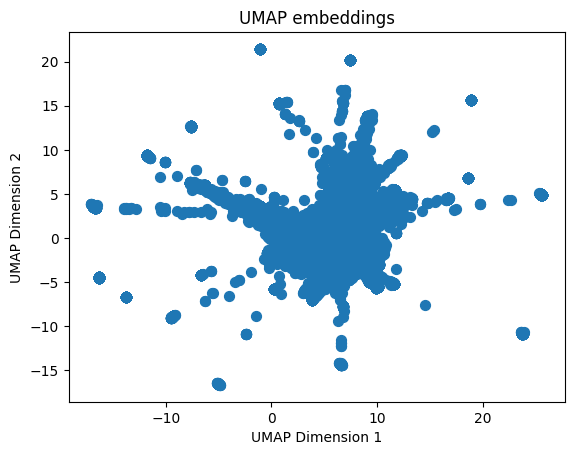

In [16]:
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=50)
# plt.colorbar(label='Cluster Label')
plt.title('UMAP embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()